### Function Approx and SARSA Control

In this report, I built a neural network to represent state action value function for Cartpole-v0 env. And then implemented both 10.1 and 10.2 as control to compare results.

**Structure of final selected neural network:**

The structure of NN has 3 hidden layers each contains 64 nodes and uses relu as activation function. It takes 4 states elements of cartpole env as input and output a 2 elements array representing values of each action at this given state input. Loss function is defined as MSE using adam optimizer.

I also explored using more hidden nodes such as 128, but that takes very long to train, therefore 64 is selected as it is a good balance of reasonable computational time while still can represent the value function.

**Control Algorithms:**

I implemeneted both episodic semi-gradient SARSA (10.1) and episodic semi-gradient n-step SARSA with n=3 (10.2). As shown by result of testing final models on 10 independent games, n-step SARSA outperforms regular SARSA. 

**Training Characteristics:**

Final selected training parameters are:

| Parameters | Value |
| ----------- |------|
| alpha   | 0.001|
| episode | 1000 |
| epsilon | 0.99 with 0.99 decay each episode and min value 0.1|
| discount gamma| 0.99|

Epsilon greedy policy is used for both algorithms, epsilon is initilaized to be 0.99 with 0.99 decay at each episode. The minimum value epsilon can decay to is 0.1.

At each step of each episode, weights of neural network is updated in a stochastic manner. And model will be fit for 1 epoch on this training input. I also explored to increase epoch number, it is observed that model performance is better when increase epoch number, because error loss is minimized. However, that requires more computational time. 

Moreover, both control algorithms are trained for 1000 episodes to make results comparable. 

**Model Performance:**

Model is evaluated by running a test of 10 independent cartpole games, average steps for 10 games are calculated.

| Model       | Average step for 10 independent games  |
| ----------- |--------------------------------------|
| SARSA | 11.4|
| n-step SARSA (n=3) | 174.3 |

As shown in the table above, when both controls are trained for 1000 episodes, model trained with n-step SARSA performes much better than SARSA. I think this is because n-step SARSA bootstraps more accurate estimations, so that the NN can train towards a more accurate target value, which eventually will result in a more accurate model.

### Python Code:

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import gym
import math

#### Create cartpole env

In [ ]:
env = gym.make('CartPole-v0')
env.reset()

array([ 0.03645906, -0.02882339,  0.04241531,  0.01546482])

#### Helper functions

In [92]:
def get_action(state, epsilon):
    if np.random.random() <= epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(model.predict(state)[0])

def reshape_state(state):
    return np.reshape(state, [1,4])

def update_weights(x_batch, y_batch):
    batch_size = 1
    train_dataset = tf.data.Dataset.from_tensor_slices((x_batch, y_batch))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    for epoch in range(1):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
          with tf.GradientTape() as tape:
            predictions = model(x_batch_train, training=True)
            ppError = f_ppError(y_batch_train, predictions)
          # compute gradients with respected to weights  
          grads = tape.gradient(ppError, model.trainable_weights)
          # apply gradidents
          optimizer.apply_gradients(zip(grads, model.trainable_weights))
          # print("Error: %f" % float(ppError))

def print_episode_steps(episode_steps):
    # print(Q)
    plt.plot(episode_steps)
    # plt.xscale("log")
    plt.xlabel("Episodes")
    plt.ylabel("Steps can achieve")
    # plt.title("Steps of episodes for " + model)
    plt.show()

def test_policy(model):
    avg_steps = []
    for iter in range(10):
      obs = env.reset()
      for i in range(50000):
        action = np.argmax(model.predict(reshape_state(obs))[0])
        obs, reward, done, info = env.step(action)
        if done:
          avg_steps.append(i+1)
          # print("Iterations that were run:", i+1)
          break
    avg = sum(avg_steps)/len(avg_steps)
    print("Average steps for policy:", avg)
    return avg

#### Build neural network model

In [93]:
def build_model():
    inputs = Input(shape=(4, ), name='state')
    # x = Dense(256, activation='relu')(inputs)
    # x = Dense(256, activation='relu')(x)
    # x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(2,
              activation='linear', 
              name='action')(x)
    model = Model(inputs, x)
    model.summary()
    return model

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           [(None, 4)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
action (Dense)               (None, 2)                 130       
Total params: 8,770
Trainable params: 8,770
Non-trainable params: 0
_________________________________________________________________


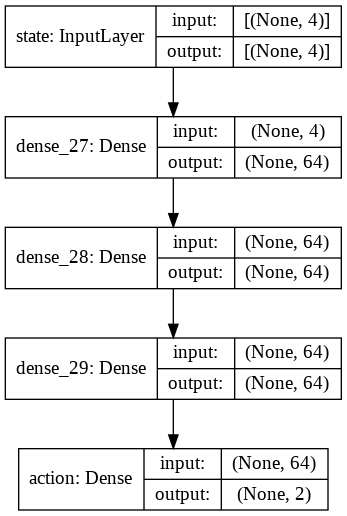

In [94]:
alpha = 0.001
optimizer=keras.optimizers.Adam(learning_rate=alpha)
f_ppError = keras.losses.MeanSquaredError()
model = build_model()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
state = env.reset()
reshape_state(state)

array([[-0.00827179, -0.03770365,  0.02733254, -0.03336646]])

#### Episodic Semi-gradient Sarsa (10.1 Algorithm)
1. Model implementation

In [95]:
def run_sarsa_0(epsilon, gamma, episodes):
    episode_steps = []
    decay = 0.9999
    min_epsilon = 0.1
    for i in range(episodes):
        if i % 100 == 0:
            print("Episodes number: ", i)
        epsilon = max(min_epsilon, epsilon * decay)
        state = env.reset()
        action = get_action(reshape_state(state), epsilon)
        step = 0
        while True:
            step += 1
            next_state, reward, done, _ = env.step(action)
            x_batch, y_batch = [], []

            if done:
                print("Total steps:", step)
                episode_steps.append(step)
                target = model.predict(reshape_state(state))
                target[0][action] = reward

                x_batch.append(reshape_state(state)[0])
                y_batch.append(target[0])
                update_weights(x_batch, y_batch)
                break

            next_state_input = reshape_state(next_state)
            next_action = get_action(next_state_input, epsilon)

            target = model.predict(next_state_input)
            target[0][action] = reward + gamma * target[0][next_action]

            x_batch.append(reshape_state(state)[0])
            y_batch.append(target[0])
            update_weights(x_batch, y_batch)

            state = next_state
            action = next_action
    return episode_steps

In [96]:
episode_steps = run_sarsa_0(0.99, 0.99, 1000)

Episodes number:  0
Total steps: 10
Total steps: 14
Total steps: 15
Total steps: 47
Total steps: 16
Total steps: 35
Total steps: 45
Total steps: 13
Total steps: 13
Total steps: 26
Total steps: 26
Total steps: 17
Total steps: 19
Total steps: 18
Total steps: 15
Total steps: 27
Total steps: 12
Total steps: 15
Total steps: 20
Total steps: 30
Total steps: 13
Total steps: 10
Total steps: 29
Total steps: 16
Total steps: 24
Total steps: 20
Total steps: 11
Total steps: 25
Total steps: 41
Total steps: 30
Total steps: 13
Total steps: 23
Total steps: 21
Total steps: 29
Total steps: 22
Total steps: 12
Total steps: 18
Total steps: 32
Total steps: 36
Total steps: 40
Total steps: 41
Total steps: 43
Total steps: 34
Total steps: 39
Total steps: 30
Total steps: 12
Total steps: 16
Total steps: 18
Total steps: 11
Total steps: 31
Total steps: 16
Total steps: 22
Total steps: 14
Total steps: 13
Total steps: 37
Total steps: 12
Total steps: 26
Total steps: 25
Total steps: 15
Total steps: 10
Total steps: 14
Tota

##### 2. Model evaluation

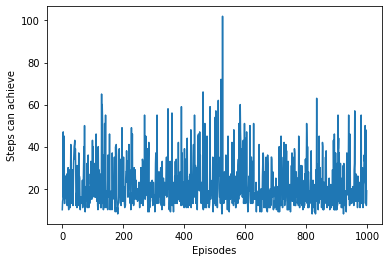

In [97]:
print_episode_steps(episode_steps)

In [100]:
test_policy(model)

Average steps for policy: 11.4


11.4

In [101]:
model.save("sarsa.h5")

#### Episodic semi-gradient n-step Sarsa
1. Model implementation

In [77]:
def n_step_sarsa(num_episodes, n, discount, epsilon):
    decay = 0.9999
    min_epsilon = 0.1
    episode_steps = []
    for i_episode in range(num_episodes):
        if i_episode % 100 == 0:
            print("Episodes number: ", i_episode)
        epsilon = max(min_epsilon, epsilon * decay)
        T = math.inf
        tau = 0
        t = -1
        actions_list = {}
        rewards_list = {}
        states_list = {}
        state = env.reset()
        state_input = reshape_state(state)
        action = get_action(state_input, epsilon)
        actions_list[0] = action
        states_list[0] = state_input
        iteration = 0

        while tau < (T - 1):
            t += 1
            if t < T:
                iteration += 1
                state, reward, done, _ = env.step(action)
                state_input = reshape_state(state)
                rewards_list[t+1] = reward
                states_list[t+1] = state_input
                
                if done: T = t + 1
                else:
                    action = get_action(state_input, epsilon)
                    actions_list[t+1] = action
            tau = t - n + 1
            if tau >= 0:
                G = np.sum([discount**(i-tau-1)*rewards_list[i] for i in range(tau+1, min(tau+n, T)+1)])
                if tau + n < T:
                    G += discount**n * model.predict(states_list[tau+n])[0][actions_list[tau+n]]
                                                                         
                tau_s, tau_a = states_list[tau], actions_list[tau]

                x_batch, y_batch = [], []
                target = model.predict(tau_s)
                target[0][tau_a] = G
                x_batch.append(tau_s[0])
                y_batch.append(target[0])
                update_weights(x_batch, y_batch)

        episode_steps.append(iteration)
        print("Total steps:", iteration)
    return episode_steps

In [82]:
# episode_steps = n_step_sarsa(200, 3, 0.99, 0.2)
episode_steps = n_step_sarsa(1000, 3, 0.99, 0.99)

Episodes number:  0
Total steps: 19
Total steps: 23
Total steps: 11
Total steps: 15
Total steps: 9
Total steps: 19
Total steps: 16
Total steps: 20
Total steps: 15
Total steps: 12
Total steps: 17
Total steps: 20
Total steps: 42
Total steps: 15
Total steps: 29
Total steps: 41
Total steps: 30
Total steps: 25
Total steps: 17
Total steps: 23
Total steps: 13
Total steps: 19
Total steps: 12
Total steps: 10
Total steps: 45
Total steps: 11
Total steps: 33
Total steps: 22
Total steps: 13
Total steps: 10
Total steps: 17
Total steps: 15
Total steps: 18
Total steps: 16
Total steps: 15
Total steps: 24
Total steps: 11
Total steps: 23
Total steps: 72
Total steps: 25
Total steps: 17
Total steps: 20
Total steps: 17
Total steps: 32
Total steps: 14
Total steps: 22
Total steps: 28
Total steps: 11
Total steps: 21
Total steps: 43
Total steps: 10
Total steps: 37
Total steps: 12
Total steps: 69
Total steps: 10
Total steps: 39
Total steps: 29
Total steps: 17
Total steps: 12
Total steps: 23
Total steps: 13
Total

2. Model evaluation

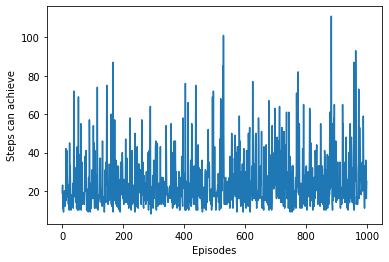

In [83]:
print_episode_steps(episode_steps)

In [86]:
test_policy(model)

Average steps for policy: 174.3


174.3

In [91]:
model.save("n_step_sarsa.h5")